In [1]:
import pysm
import pysm.units as u

import matplotlib.pyplot as plt
import corner

import jax.numpy as np
from jax import grad, hessian
import jax

from scipy.optimize import minimize
import numpy as old_np
import healpy as hp
import emcee

from hoover.seds import FMatrix
from hoover.likelihood import LogProb
from hoover.tools import WhiteNoise
from jax.config import config
config.update("jax_enable_x64", True)

# Simulations

Use `pysm` to generate some observed sky maps. Create sky model with the `d1` and `s1` dust and synchrotron models, respectively.

In [2]:
nside = 64
sky = pysm.Sky(nside=nside, preset_strings=["d1", "s1", "c2"])

Define the frequencies at which to observe the `pysm` model. Define the the sensitivities in $\mu K~{\rm amin}$, and convert to $\mu K_{\rm RJ}~{\rm amin}$.

In [61]:
freqs = old_np.array([27., 39., 93., 145., 225., 280.]) * u.GHz
sens = np.array([35., 21, 2.6, 3.3, 6.3, 16.]) * u.uK_CMB
sens = np.array([w.to(u.uK_RJ, equivalencies=u.cmb_equivalencies(f)) for w, f in zip(sens, freqs)])

Evaluate `pysm` model at the given frequencies

In [62]:
out = np.concatenate(list(sky.get_emission(f)[None, 1:, ...] for f in freqs))

Generate white noise realizations with the given sensitivities, and add to the observed sky. Note that we have to cast the `noise.map` object to a true `numpy` array, as it is returned from `WhiteNoise` as a `jax` `DeviceArray` object.

In [63]:
noise = WhiteNoise(sens=sens)
noise_map = old_np.asarray(noise.map(nside))

In [64]:
cov = noise.get_pix_var_map(nside)

In [65]:
noisy_obs = noise_map + out

# Likelihood Model

We now define the likelihood model. 

First, we set up the `FMatrix` object. This requires specifying the SED for each of the components we want to fit. Here, we fit two components, a `dustmbb` and a `syncpl` component. These must correspond to functions defined in `hoover.seds`. We also define a default set of parameter values for these SEDs. We can change the likelihood to be a function of any of these parameters later.  

Also define the Gaussian priors on each of the parameters we want to allow to vary. The format for this is a dictionary with keys corresponding to the parameter name, and values being a tuple containing the mean and standard deviation of the prior.

In [66]:
sed = FMatrix(['dustmbb', 'syncpl', 'cmb'])
parameters = {'nu': freqs.value, 'nu_ref_d': np.float32(353), 'nu_ref_s': np.float32(23.), 'beta_d': np.float32(1.5), 'beta_s': np.float32(-3.), 'T_d': np.float32(20)}
priors = {'beta_d': (1.5, 0.4), 'beta_s': (-3., 0.5)}

Initialize the `LogProb` object. This object calculates the spectral parameter likelihood, having marginalized over amplitudes:

$$
\log \mathcal{L}\left(\mathbf{b} | \mathbf{d} \right) \propto p_p(\mathbf{b}) \exp(\frac{1}{2} \bar{\mathbf{T}}^T N_T^{-1} \bar{\mathbf{T}})
$$

In [67]:
lnP = LogProb(noisy_obs, cov, sed, priors=priors)

As a sanity check, lets see if setting $\beta_d$ and $\beta_s$ to a constant (across the sky) value gives reasonable-looking dust and synchrotron maps:

In [70]:
dust, sync, cmb = sky.components

False


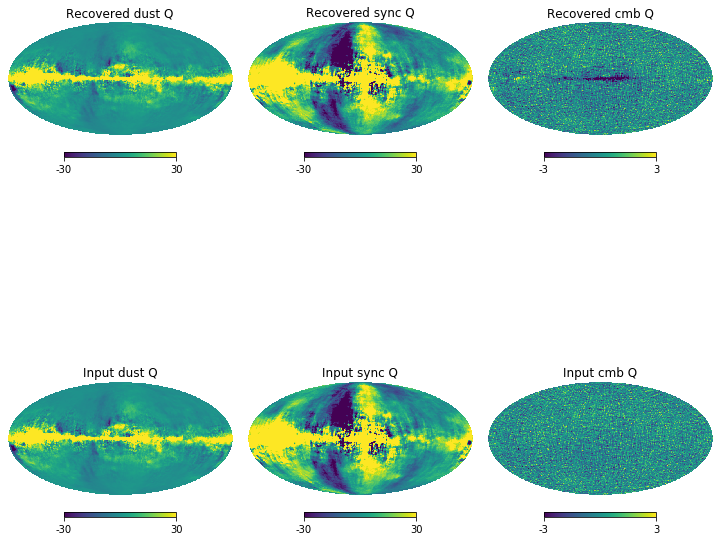

In [71]:
dust, sync, cmb = sky.components # input maps to the simulation
tbar = lnP.get_amplitude_expectation(parameters) # T_bar evaluated for constant spectral index

fig = plt.figure(figsize=(10, 10))
hp.mollview(tbar[0, 0], sub=(231), min=-30, max=30, title="Recovered dust Q")
hp.mollview(tbar[1, 0], sub=232, min=-30, max=30, title="Recovered sync Q")
hp.mollview(tbar[2, 0], sub=233, min=-3, max=3, title="Recovered cmb Q")
hp.mollview(old_np.asarray(dust.Q_ref), sub=(234), min=-30, max=30, title="Input dust Q")
hp.mollview(old_np.asarray(sync.Q_ref), sub=235, min=-30, max=30, title="Input sync Q")
hp.mollview(old_np.asarray(cmb.map[1]), sub=236, min=-3, max=3, title="Input cmb Q")

The `d1` and `s1` `pysm` models have spatially varying spectral indices, but so far we have modelled them as constant, so we have some residuals when differencing the maps (in addition to the noise resiudals you would expect in any case):

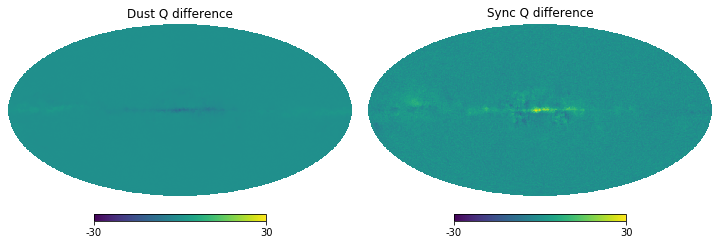

In [73]:
fig = plt.figure(figsize=(10, 5))
hp.mollview(tbar[0, 0] - old_np.asarray(dust.Q_ref), sub=(121), min=-30, max=30, title="Dust Q difference")
hp.mollview(tbar[1, 0] - old_np.asarray(sync.Q_ref), sub=122, min=-30, max=30, title="Sync Q difference")

# Inference with the likelihood 

The likelihood object `LogProb` can be thought of as a function of any subset of spectral parameters.

The likelihood code is implemented in `jax`, which allows us to take derivatives of the likelihood with respect to any of the SED parameters.

In [74]:
func = lambda beta: - lnP(parameters, beta_d=beta[0], beta_s=beta[1])
gfunc = grad(func)
hfunc = hessian(func)

We can maximize the likelihood with respect to the spectral parameters $\beta_d$, $\beta_s$:

In [75]:
res = minimize(func, np.array([1.4, -3.4]), method='Nelder-Mead')

In [76]:
print(res)

final_simplex: (array([[ 1.53327622, -2.94160935],
       [ 1.53327655, -2.94159547],
       [ 1.5332825 , -2.94161365]]), array([-4.71338982e+09, -4.71338982e+09, -4.71338982e+09]))
           fun: -4713389822.995052
       message: 'Optimization terminated successfully.'
          nfev: 68
           nit: 35
        status: 0
       success: True
             x: array([ 1.53327622, -2.94160935])


And make a Fisher estimate of the uncertainties in the ML values:

In [77]:
hess = hfunc(res.x)

In [78]:
fish = np.linalg.inv(hess)
print(np.sqrt(fish))

[[0.00013485        nan]
 [       nan 0.00053464]]


How does this compare to if we sampled the posterior?

In [79]:
ndim, nwalkers = 2, 10
key = jax.random.PRNGKey(748)
# set an array of starting positions for the different walkers
p0 = jax.random.normal(key, shape=(nwalkers, ndim))
p0 *= 0.01
p0 += res.x[None, :]

In [80]:
# define the posterior to sample from
func = lambda beta: lnP(parameters, beta_d=beta[0], beta_s=beta[1])
sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
sampler.run_mcmc(p0, 1000)

State([[ 1.53319854 -2.941784  ]
 [ 1.53309384 -2.94158776]
 [ 1.53337141 -2.94215819]
 [ 1.53318081 -2.94153171]
 [ 1.53330057 -2.94178803]
 [ 1.53326831 -2.94163719]
 [ 1.53327724 -2.94098935]
 [ 1.53321035 -2.94144825]
 [ 1.53313066 -2.94190115]
 [ 1.53324278 -2.94079671]], log_prob=[4.71338982e+09 4.71338982e+09 4.71338982e+09 4.71338982e+09
 4.71338982e+09 4.71338982e+09 4.71338982e+09 4.71338982e+09
 4.71338982e+09 4.71338982e+09], blobs=None, random_state=('MT19937', array([3653756217, 1244313016, 1705574343, 2614763279,   50061290,
       3656557784, 3767135396, 3377868059, 3308758687, 3119355878,
       1823061705,   88396103,  755216923, 4033821637, 2226202914,
       3223574059, 1977855709, 4248073605, 1301162741,   85721181,
       2686472582, 4053077292, 4280967065, 1863312996, 3198892993,
       3790650855,  145189687, 3560860039, 2262315243, 1610191478,
       3298409968,  869535274, 1537709748, 1379376550, 1303143569,
        504890603, 2315793332, 1598096132, 194295351

In [86]:
chain = sampler.get_chain(flat=True, discard=200)

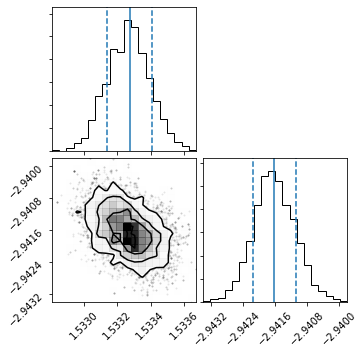

In [87]:
fig = corner.corner(chain)
axes = fig.axes
xs = np.arange(*axes[0].get_xlim())
beta_d_fish = np.sqrt(fish[0, 0])
beta_s_fish = np.sqrt(fish[1, 1])

axes[0].axvline(x=res.x[0])
axes[0].axvline(x=res.x[0] - np.sqrt(fish[0, 0]), ls='--')
axes[0].axvline(x=res.x[0] + np.sqrt(fish[0, 0]), ls='--')

axes[-1].axvline(x=res.x[1])
axes[-1].axvline(x=res.x[1] - np.sqrt(fish[1, 1]), ls='--')
axes[-1].axvline(x=res.x[1] + np.sqrt(fish[1, 1]), ls='--')

In [89]:
out = np.zeros((3, 2, hp.nside2npix(nside)))
for pars in chain:
    out += lnP.get_amplitude_expectation(parameters, beta_d=pars[0], beta_s=pars[1])
out = out / float(chain.shape[0])

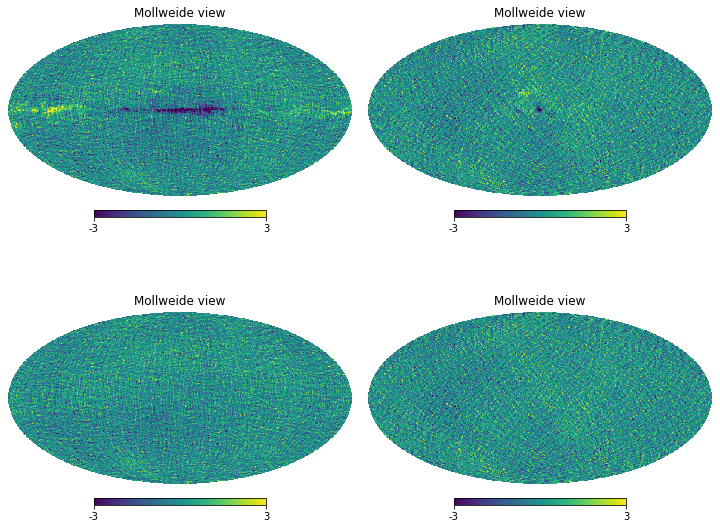

In [96]:
fig = plt.figure(figsize=(10, 8))
kwargs = {'min': -3, 'max': 3}
hp.mollview(out[2, 0], sub=221, **kwargs)
hp.mollview(out[2, 1], sub=222, **kwargs)
hp.mollview(cmb.map[1], sub=223, **kwargs)
hp.mollview(cmb.map[2], sub=224, **kwargs)

In [ ]:
chain.shape